In [68]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [69]:
import numpy as np
import pandas as pd

In [70]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [71]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [72]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [73]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [74]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [75]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [76]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

In [77]:
#Taking a look in the data
row1m = session.query(Measurement).first()
row1m.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x11fb83410>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01'}

In [78]:
row1s = session.query(Station).first()
row1s.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x11fb7cbd0>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0}

# Exploratory Climate Analysis

In [79]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# 1.- Calculate the date 1 year ago from the last data point in the database
# Here I take a look on data composition first, last and total records
print ( f' first date : {session.query(Measurement.date).order_by(Measurement.date).first()}, last date : {session.query(Measurement.date).order_by(Measurement.date.desc()).first()}, total dates : {session.query(func.count(Measurement.date)).all()}' )

first date : ('2010-01-01',), last date : ('2017-08-23',), total dates : [(19550,)]


In [80]:
# The last date is 2017-08-23 so a year after we are looking for is 2016-08-23
last_12_months = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(f"Last 12 months start at {last_12_months}")

Last 12 months start at 2016-08-23


In [81]:
# Perform a query to retrieve the date and precipitation scores
points = [Measurement.date, Measurement.prcp, Measurement.station ]
last_12_months_data = session.query(*points).filter(Measurement.date > f'{last_12_months}').order_by(Measurement.date)
#Printing one result
last_12_months_data[0]

('2016-08-24', 0.08, 'USC00519397')

In [82]:
# Save the query results as a Pandas DataFrame 
data = pd.DataFrame(last_12_months_data)
#and set the index to the date column
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data.head()


,prcp,station
date,,
2016-08-24,0.08,USC00519397
2016-08-24,2.15,USC00513117
2016-08-24,2.28,USC00514830
2016-08-24,NaN,USC00517948
2016-08-24,1.22,USC00519523


In [83]:
# Sort the dataframe by date
data.sort_index()
data.head()

,prcp,station
date,,
2016-08-24,0.08,USC00519397
2016-08-24,2.15,USC00513117
2016-08-24,2.28,USC00514830
2016-08-24,NaN,USC00517948
2016-08-24,1.22,USC00519523


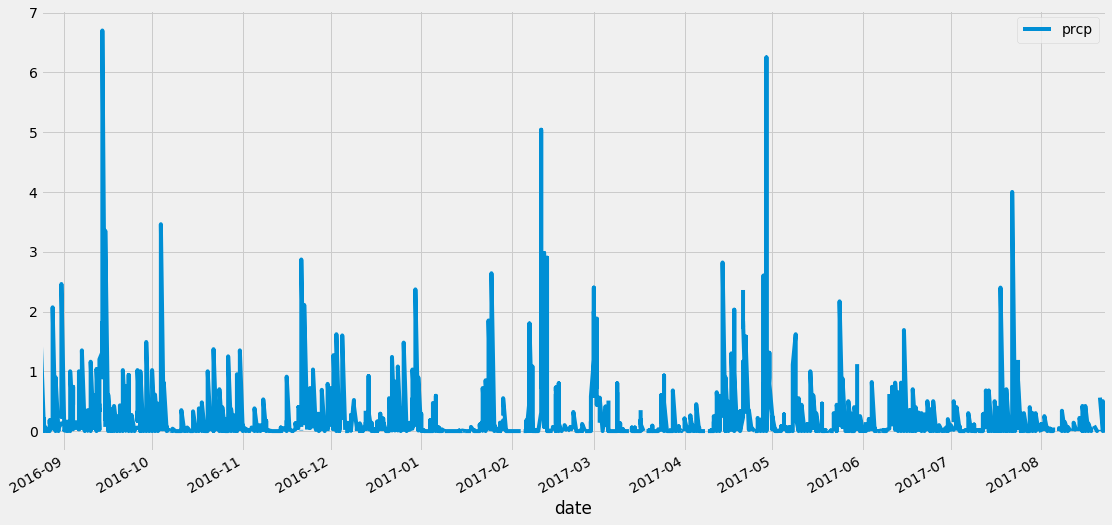

In [84]:
# Use Pandas Plotting with Matplotlib to plot the data
data.plot.line(figsize=(17,9))

In [85]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [86]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(Measurement.station).group_by(Measurement.station).count()
print(f"There are {stations_count} stations in this dataset")


There are 9 stations in this dataset


In [87]:
from sqlalchemy import distinct
# What are the most active stations? (i.e. what stations have the most rows)?
stations = session.query(Measurement.station, func.count(Measurement.date)).group_by(Measurement.station).order_by(func.count(Measurement.date).desc())
# List the stations and the counts in descending order.
for x in stations:
    print(x)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [88]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
lowest_temp = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').order_by(Measurement.tobs.asc()).first()
print(f'The lowest temperature recorded from station USC00519281 was {round(lowest_temp[0])}')
# highest temperature recorded, 
highest_temp = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').order_by(Measurement.tobs.desc()).first()
print(f'The hightest temperature recorded from station USC00519281 was {round(highest_temp[0])}')
# and average temperature of the most active station?
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
print(f'The average recorded temperature from station USC00519281 was {round(avg_temp[0][0],2)}') 

The lowest temperature recorded from station USC00519281 was 54
The hightest temperature recorded from station USC00519281 was 85
The average recorded temperature from station USC00519281 was 71.66


In [89]:
# Choose the station with the highest number of temperature observations.
high_temp_station = session.query(func.max(Measurement.tobs), Measurement.station).all()
print(f'The station with the highest temperature record was {high_temp_station[0][1]}, who registered a temperature of {high_temp_station[0][0]}')


The station with the highest temperature record was USC00519397, who registered a temperature of 87.0


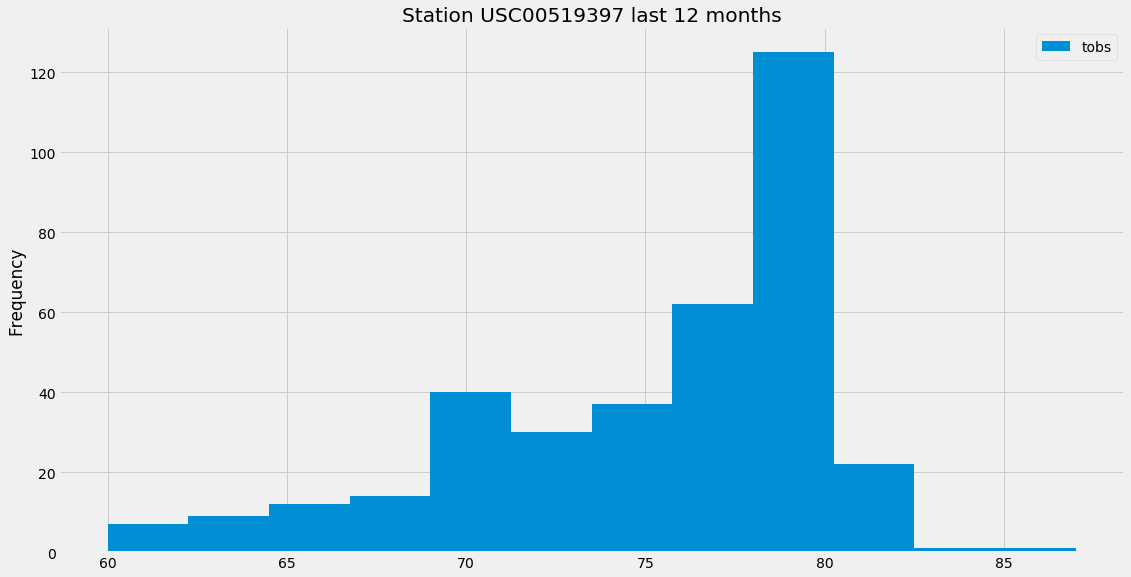

In [90]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
from sqlalchemy import and_
months_station397 = session.query(Measurement.date, Measurement.tobs).filter(and_(Measurement.station == "USC00519397", Measurement.date > f'{last_12_months}')).order_by(Measurement.date.desc()).all()
months_station397 = pd.DataFrame(months_station397)
months_station397.plot.hist(figsize=(17,9), bins=12)
plt.title("Station USC00519397 last 12 months")
plt.show()


## Bonus Challenge Assignment

In [91]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return list(session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all())

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [92]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#Here I create a for loop to itaret throw the dates and aply the function calc_temps, also appending year.
data_list = []
date_list = []
start_d = dt.date(2017, 7, 1)
end_d = dt.date(2017, 7, 16)
for x in range(1,9,1):
    data_list.append(calc_temps(start_d, end_d))
    date_list.append(end_d.year)
    start_d = dt.date(2018 - x, 7, 1) - dt.timedelta(days=365)
    end_d = dt.date(2018 - x, 7, 16) - dt.timedelta(days=365)

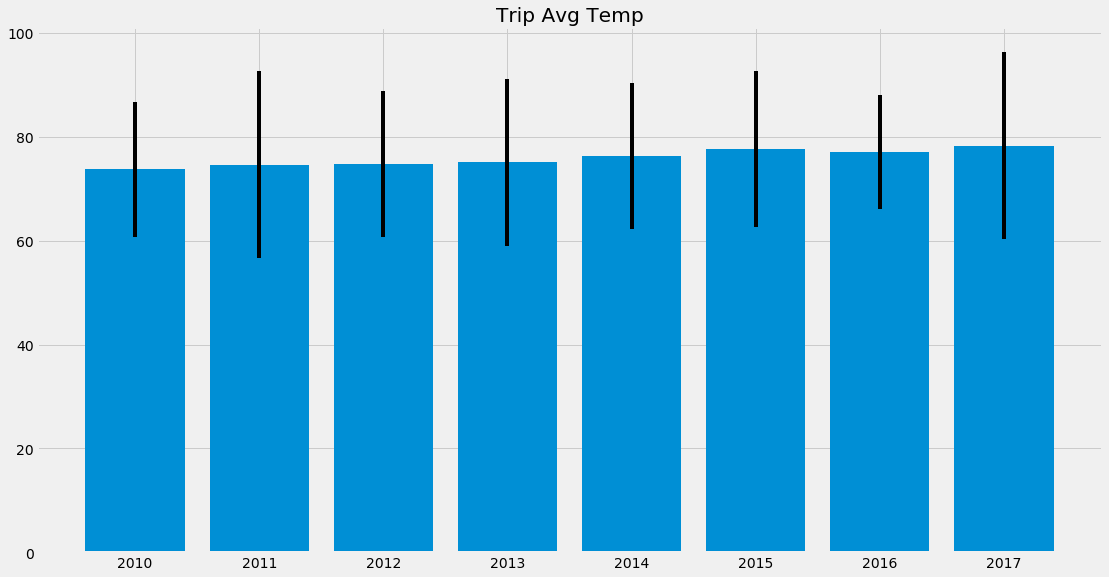

In [93]:
# Plot the results from your previous query as a bar chart. 
# Use the average temperature for the y value
    #I had to iterate through the given tuple to get independent values
y_values  = [x [0][1] for x in data_list ]
x_values = date_list
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
    #I had to iterate through the given tuple to get independent values 
tmax = [x [0][0] for x in data_list]
tmin = [x [0][2] for x in data_list]
    #So here I substract one list from another to get the asked peak list 
max_min = []
max_min.append(list(x - y for x, y in zip(tmin,tmax,)))

#Now we can start plotting
plt.figure(figsize=(17,9))
plt.bar(x_values, y_values, yerr=max_min[0])
# Use "Trip Avg Temp" as your Title
plt.title('Trip Avg Temp')
plt.show()


In [121]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_d = dt.date(2017, 7, 1)
end_d = dt.date(2017, 7, 16)
total_rain = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
filter(Station.station == Measurement.station).filter(Measurement.date >= f'{start_d}').filter(Measurement.date <= f'{end_d}').\
group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()
total_rain

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  3.3700000000000006),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  1.7400000000000002),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  0.9000000000000001),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  0.22999999999999998),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.13),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.51)]

In [95]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [155]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals=[]
trip_dates = []

# Set the start and end date of the trip
start_d = dt.date(2017, 7, 1)
end_d = dt.date(2017, 7, 16)

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date

#I skiped all that and solved it through this two for loop.
#Because while using dt.date it just gives me a 7-1 date format, so it didn't work
for x in range(1,10,1):
    date = f'07-0{x}'
    trip_dates.append(date)
    normals.extend(daily_normals(date))

for x in range(10,17,1):
    date = f'07-{x}'
    trip_dates.append(date)
    # I use extend and not append to avoid messy lists like [(67.0, 74.77777777777777, 81.0)]
    #And also avoid problems while exporting to dataframe
    normals.extend(daily_normals(date))
normals

[(67.0, 74.77777777777777, 81.0),
 (68.0, 75.40384615384616, 82.0),
 (68.0, 75.32075471698113, 87.0),
 (70.0, 76.57142857142857, 81.0),
 (66.0, 75.0, 81.0),
 (69.0, 75.0, 81.0),
 (69.0, 74.91071428571429, 82.0),
 (69.0, 76.08333333333333, 83.0),
 (68.0, 76.19298245614036, 83.0),
 (68.0, 75.62068965517241, 82.0),
 (70.0, 75.78947368421052, 81.0),
 (67.0, 75.96491228070175, 82.0),
 (69.0, 76.1896551724138, 81.0),
 (61.0, 76.2280701754386, 82.0),
 (68.0, 76.2542372881356, 82.0),
 (70.0, 76.34482758620689, 83.0)]

In [157]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip = pd.DataFrame (normals, columns = ["tmin", 'tavg', 'tmax'])
trip['date'] = trip_dates
trip.set_index('date', inplace=True)
trip.head()

,tmin,tavg,tmax
date,,,
07-01,67.0,74.777778,81.0
07-02,68.0,75.403846,82.0
07-03,68.0,75.320755,87.0
07-04,70.0,76.571429,81.0
07-05,66.0,75.000000,81.0


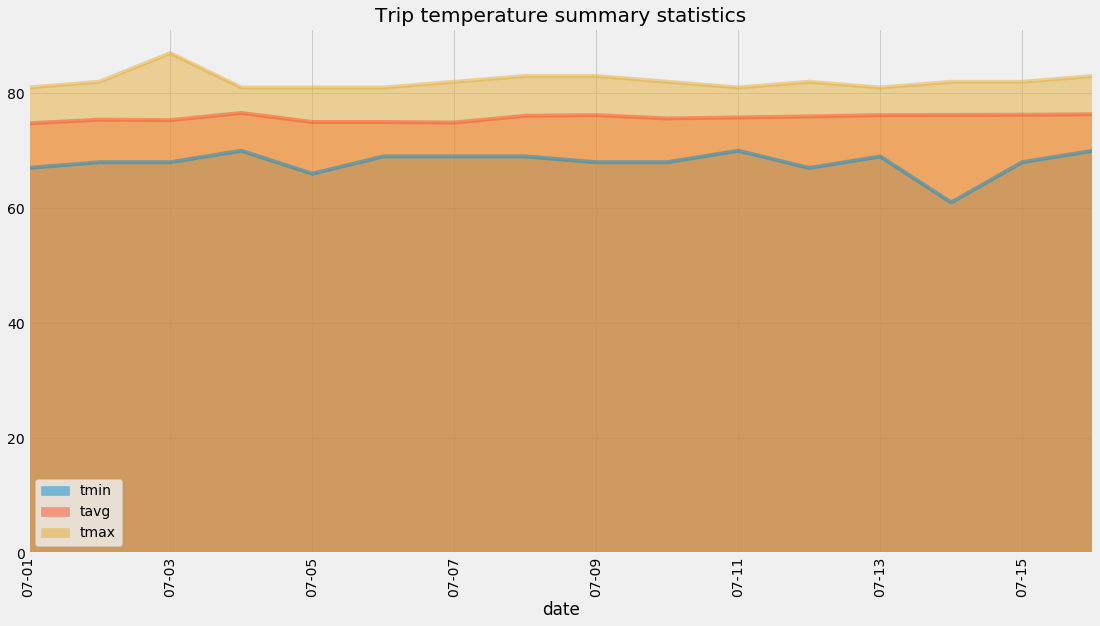

In [162]:
# Plot the daily normals as an area plot with `stacked=False`
trip.plot.area(stacked=False, figsize=(17,9))
plt.xticks(rotation=90)
plt.title("Trip temperature summary statistics")
plt.show()
